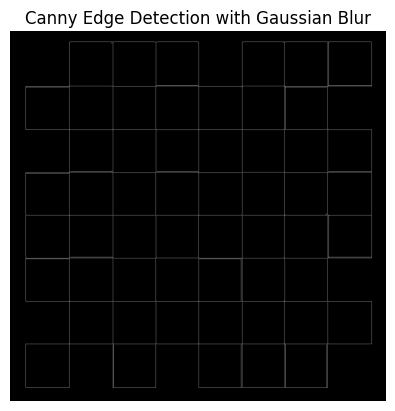

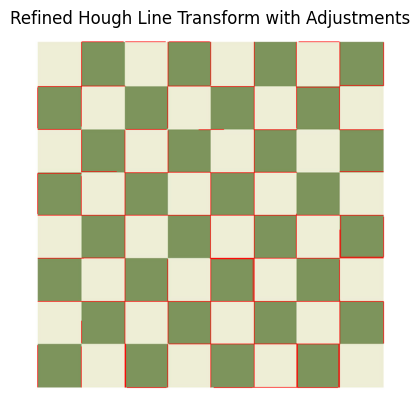

C:\Users\danim\AppData\Local\Temp\ipykernel_12964\1404942022.py:83: RuntimeWarning: overflow encountered in scalar multiply
  intersect_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
C:\Users\danim\AppData\Local\Temp\ipykernel_12964\1404942022.py:84: RuntimeWarning: overflow encountered in scalar multiply
  intersect_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom


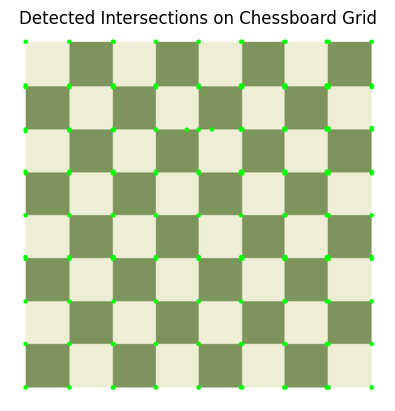

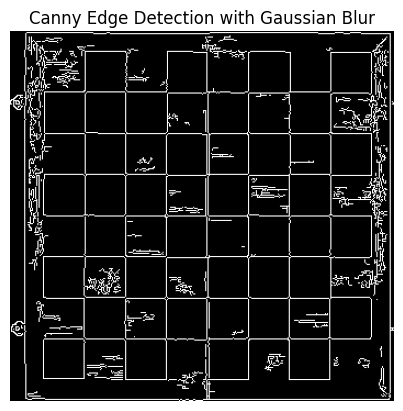

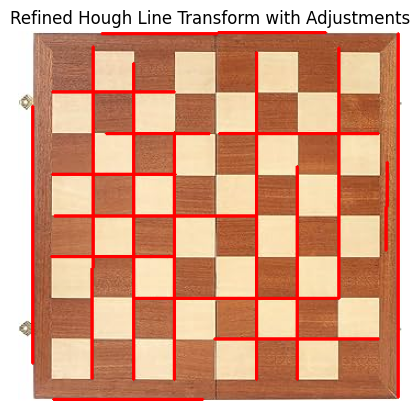

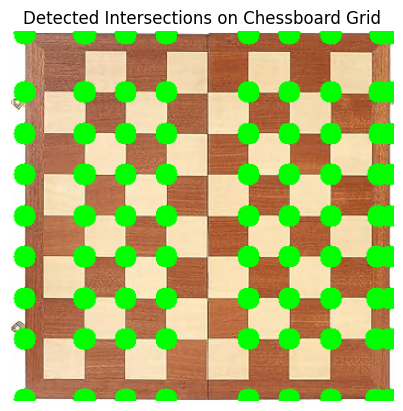

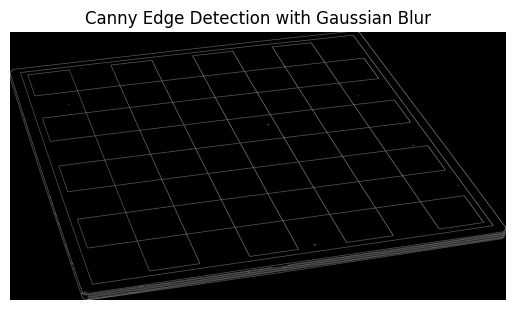

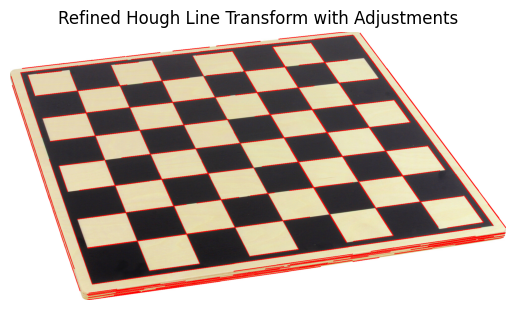

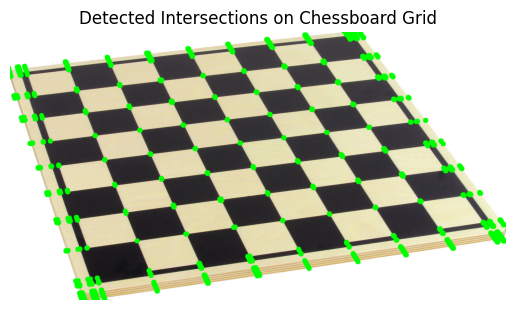

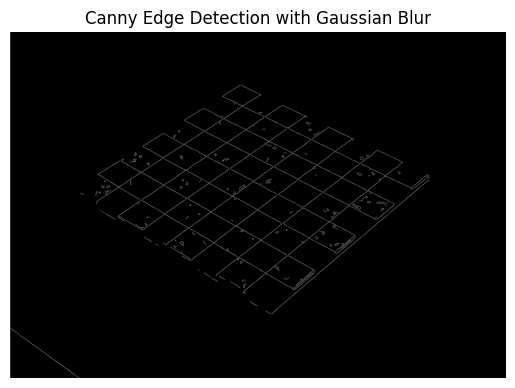

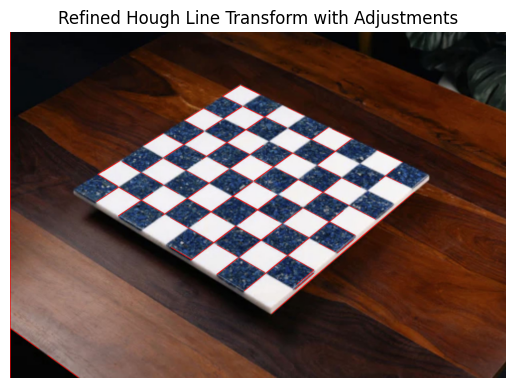

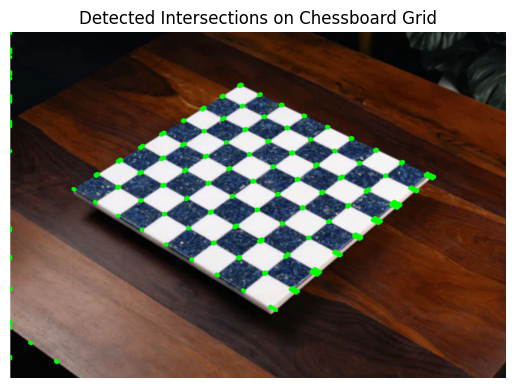

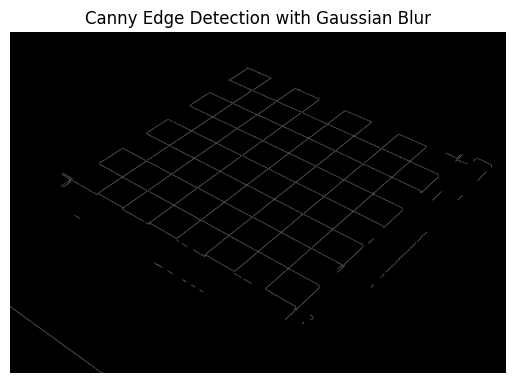

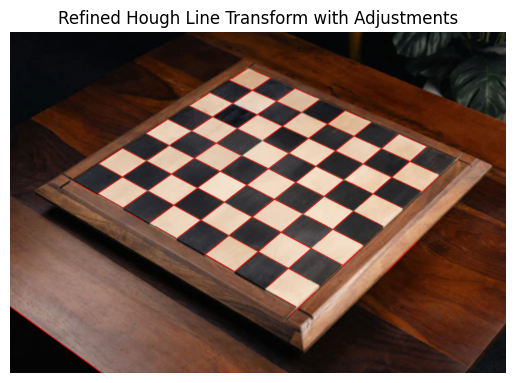

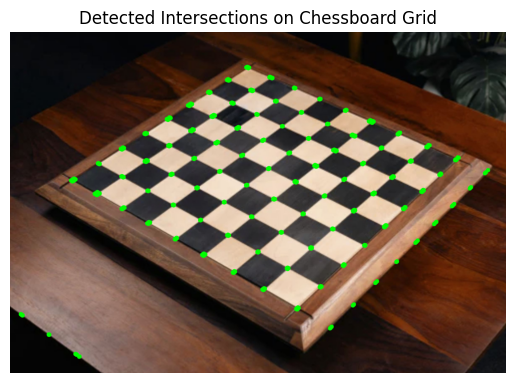

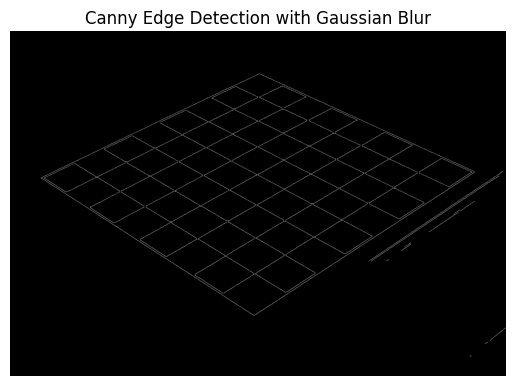

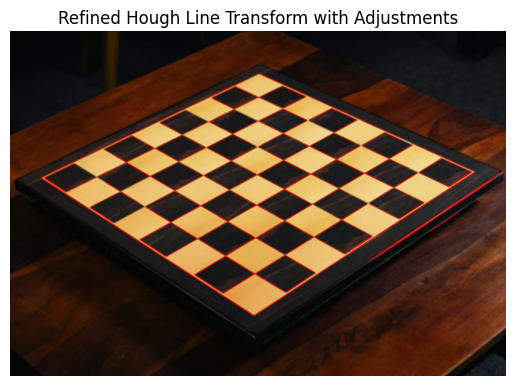

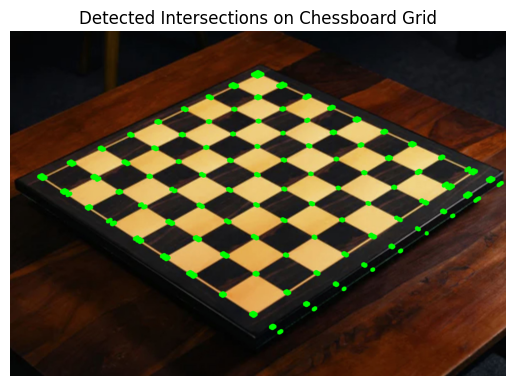

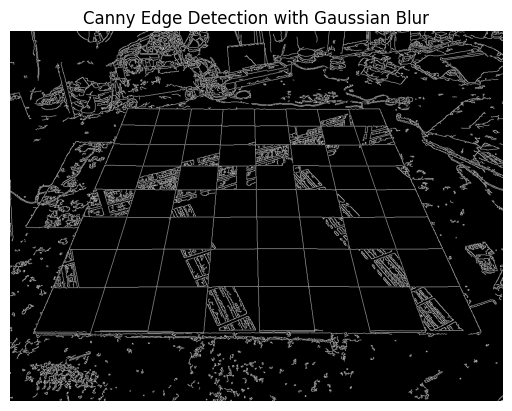

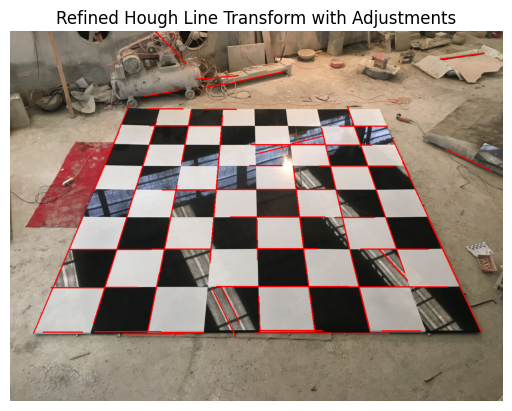

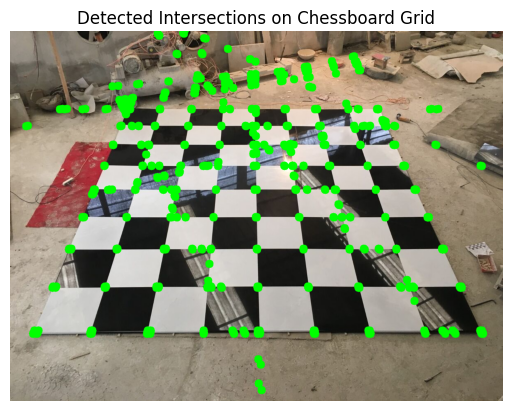

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Detect lines using Hough Line Transform
def detect_lines(image, threshold=80, min_line_length=85, max_line_gap=5):
    """
    Detect lines in the image using Hough Line Transform.
    """
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Canny edge detection
    edges = cv2.Canny(gray_image, 50, 150)

    # Display the result
    plt.imshow(edges, cmap='gray')
    plt.title("Canny Edge Detection with Gaussian Blur")
    plt.axis('off')
    plt.show()
    
    # Apply Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold, minLineLength=min_line_length, maxLineGap=max_line_gap)
    
    # Draw the lines on the original image for visualization
    line_image = image.copy()  # Make a copy of the original image
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Draw in red

    # Display the image with detected lines
    plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
    plt.title("Refined Hough Line Transform with Adjustments")
    plt.axis('off')
    plt.show()

    return lines

# Step 2: Classify lines by their orientation angle
def classify_lines_by_angle(lines):
    """
    Classify lines into groups based on their angle, considering that the image can be taken at any angle.
    """
    line_groups = []
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # Calculate the angle of the line using atan2
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi  # Angle in degrees
        
        # Normalize the angle to [0, 180] degrees range
        if angle < 0:
            angle += 180
        
        # Classify the lines into groups based on their angle
        added = False
        for group in line_groups:
            # If the angle is close to an existing group, add it to that group
            if abs(angle - group[0][0]) < 10:  # Tolerance of 10 degrees
                group.append((angle, (x1, y1, x2, y2)))
                added = True
                break
        
        # If no group was found, create a new group
        if not added:
            line_groups.append([(angle, (x1, y1, x2, y2))])
    
    return line_groups

# Step 3: Find the intersection of two lines
def find_intersection(line1, line2):
    """
    Calculate the intersection point of two lines, if they intersect.
    """
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    
    if denom == 0:
        return None  # Parallel lines, no intersection
    
    intersect_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
    intersect_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom
    return (intersect_x, intersect_y)

# Step 4: Detect intersections between groups of lines
def detect_intersections(line_groups):
    """
    Find all intersections between lines from different angle groups.
    """
    intersections = []
    
    # Loop through each pair of groups and find intersections
    for i in range(len(line_groups)):
        for j in range(i + 1, len(line_groups)):
            for line1 in line_groups[i]:
                for line2 in line_groups[j]:
                    intersection = find_intersection(line1[1], line2[1])
                    if intersection:
                        intersections.append(intersection)
    
    return np.array(intersections)

# Step 5: Draw the intersections on the image
def draw_intersections(image, intersections):
    """
    Draw green circles at the intersection points on the image.
    """
    intersection_image = image.copy()
    for point in intersections:
        cv2.circle(intersection_image, (int(point[0]), int(point[1])), 10, (0, 255, 0), -1)  # Green dots
    
    return intersection_image

# --- Main Execution Flow ---
# List of image paths
image_paths = [
    'data/boards/reference_chessboard_pattern.jpg',
    'data/boards/black_board_difficult_corners.jpg',
    'data/boards/board_tilted.jpg',
    'data/boards/irl_chessboard_1.JPG',
    'data/boards/irl_chessboard_2.JPG',
    'data/boards/irl_chessboard_3.JPG',
    'data/boards/irl_chessboard_4.JPG',
]


# Load the image
for image_path in image_paths:
    # Load your chessboard image
    image = cv2.imread(image_path)

    # Detect lines in the image
    lines = detect_lines(image)

    # Classify the lines based on their angle
    line_groups = classify_lines_by_angle(lines)

    # Detect intersections between different line groups
    intersections = detect_intersections(line_groups)

    # Draw intersections on the image
    intersection_image = draw_intersections(image, intersections)

    # Display the result
    plt.imshow(cv2.cvtColor(intersection_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Intersections on Chessboard Grid")
    plt.axis('off')
    plt.show()
